# Univariate LSTM

In [1]:
#import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math

In [2]:
#Data sequencing function 
def univariate_single_step(sequence, window_size):
    x, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + window_size
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)


## Hyper parameter

In [3]:
split_ratio = 0.70
num_epochs = 60
window_size = 2
batch_size = 1
#seed
torch.manual_seed(123)

# Data Preparation

In [4]:
#Synthetic Data
univariate_series = np.array([x for x in range(0, 400, 10)])
print(univariate_series.shape)
univariate_series

(40,)


array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
       390])

## Data Splitting

In [5]:
split_data = round(len(univariate_series)*split_ratio)
split_data

28

In [6]:
#split data by indexing 
train_data = univariate_series[:split_data]
test_data = univariate_series[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(28,)
test_data_shape
(12,)


## Data Normalization

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

test_data_normalized = scaler.fit_transform(test_data.reshape(-1, 1))

## Data Sequencing

In [8]:
trainX ,trainY =  univariate_single_step(train_data_normalized,window_size)
testX , testY = univariate_single_step(test_data_normalized,window_size)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testX shape:{testY.shape}")


trainX shape:(26, 2, 1) trainY shape:(26, 1)

testX shape:(10, 2, 1) testX shape:(10, 1)


## Data Transform

In [9]:
#transfrom to Pytorch tensor
trainX = torch.from_numpy(trainX).type(torch.Tensor)
trainY = torch.from_numpy(trainY).type(torch.Tensor)
testX = torch.from_numpy(testX).type(torch.Tensor)
testY = torch.from_numpy(testY).type(torch.Tensor)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:torch.Size([26, 2, 1]) trainY shape:torch.Size([26, 1])

testX shape:torch.Size([10, 2, 1]) testY shape:torch.Size([10, 1])


In [10]:
print(f"Features are now in the shape of {trainX.shape} while labels are now in the shape of {trainY.shape}\n")
print("x-feature\n"+str(trainX.shape[0])+" = total number of data ")
print(str(trainX.shape[1])+" = window size ")
print(str(trainX.shape[2])+" = number of time series\n")
print("y-label\n"+str(trainY.shape[0])+" = number of data")
print(str(trainY.shape[1])+" = number of step\n")

Features are now in the shape of torch.Size([26, 2, 1]) while labels are now in the shape of torch.Size([26, 1])

x-feature
26 = total number of data 
2 = window size 
1 = number of time series

y-label
26 = number of data
1 = number of step



In [11]:
# Create Iterator
train_dataset = TensorDataset(trainX, trainY)
train_iter = DataLoader(train_dataset,batch_size=batch_size,shuffle=False)

test_dataset = TensorDataset(testX, testY)
test_iter = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

# LSTM Model Configuration 

## Vanila LSTM

In [12]:
class LSTM(nn.Module):

        def __init__(self, n_feature, hidden_dim, num_layers, output_dim):
            super(LSTM, self).__init__()

            self.n_feature = n_feature
            # Hidden dimensions
            self.hidden_dim = hidden_dim

            # Number of hidden layers
            self.num_layers = num_layers

            # Building your LSTM
            # batch_first=True causes input/output tensors to be of shape
            # (batch_dim, seq_dim, feature_dim)
            self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True)

            # Readout layer
            self.fc = nn.Linear(hidden_dim, output_dim)


        def forward(self, x):
            # Initialize hidden state with zeros
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

            # Initialize cell state
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

            # One time step
            # We need to detach as we are doing truncated backpropagation through time (BPTT)
            # If we don't, we'll backprop all the way to the start even after going through another batch
            out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

            # Index hidden state of last time step
            # out.size() --> 100, 28, 100
            # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
            out = self.fc(out[:, -1, :])
            # out.size() --> 100, 10
            return out

## Bidirectional LSTM

In [13]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, n_feature, hidden_dim, num_layers, output_dim):
        super(BidirectionalLSTM, self).__init__()

        self.n_feature = n_feature
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True,bidirectional=True)

        # Readout layer *2 for bidirectional LSTM
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = self.fc(out[:, -1, :])
        
        return out

## Model Deployment

In [14]:
#Arguments for LSTM model
hidden_dim = 10
number_of_time_series = 1 
timestep = 1 

#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 3 

#Vanila , Stacked LSTM
model = LSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim, output_dim=timestep, num_layers=num_layers)

#Bidirectional LSTM
# model = BidirectionalLSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim, output_dim=timestep, num_layers=num_layers)


In [15]:
#loss function 
loss_fn = torch.nn.MSELoss()

#optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

## Training

In [16]:
def training(num_epochs,train_iter,test_iter,optimiser,loss_fn,model):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    for t in range(num_epochs):
        # Initialise hidden state
    #     Don't do this if you want your LSTM to be stateful
    #     model.hidden = model.init_hidden()
        running_loss_train = 0
        running_loss_valid = 0
        for _,(train_X,train_Y) in enumerate(train_iter):


            # Forward pass
            y_train_pred = model(train_X)

            #Reshape to perform MSE 
            y_train_pred=torch.reshape(y_train_pred,(train_Y.shape[0],train_Y.shape[1]))

            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimiser.step()

            running_loss_train += loss_train.item()

        epoch_loss_train = running_loss_train /len(train_X)
        train_loss[t] = epoch_loss_train





        with torch.no_grad():
            for _,(test_X,test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                #Reshape to perform MSE 
                y_test_pred=torch.reshape(y_test_pred,(test_Y.shape[0],test_Y.shape[1]))
                loss_test = loss_fn(y_test_pred, test_Y)
                running_loss_valid += loss_test.item()

        epoch_loss_test =running_loss_valid /len(test_X)

        val_loss[t] = epoch_loss_test
    
    return train_loss,val_loss

In [17]:
train_loss,val_loss = training(num_epochs,train_iter,test_iter,optimiser,loss_fn,model)

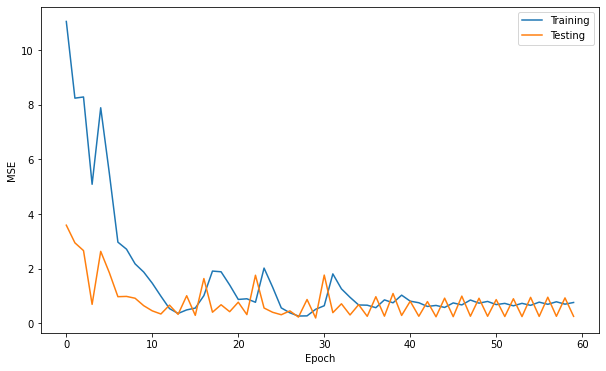

In [18]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label="Training")
plt.plot(val_loss, label="Testing")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

## Inference

In [19]:
# make predictions
y_train_prediction = model(trainX)
y_test_prediction = model(testX)

#Reshape to original data
y_train_prediction= torch.reshape(y_train_prediction,(y_train_prediction.shape[0],y_train_prediction.shape[1]))
trainY = torch.reshape(trainY,(trainY.shape[0],trainY.shape[1]))
y_test_prediction = torch.reshape(y_test_prediction,(y_test_prediction.shape[0],y_test_prediction.shape[1]))
testY = torch.reshape(testY,(testY.shape[0],testY.shape[1]))

In [20]:
#Invert predictions
y_train_prediction= scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(trainY.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(testY.detach().numpy())

In [21]:
print("y-test\t\ty-predict")
for i in range(len(y_test_prediction)):
    print(f"{y_test[i]}\t\t{y_test_prediction[i]}")

y-test		y-predict
[300.]		[310.20367]
[310.]		[311.43823]
[320.]		[315.70956]
[330.]		[329.74063]
[340.]		[338.36484]
[350.]		[342.25262]
[360.]		[350.28894]
[370.]		[360.10208]
[380.]		[367.71237]
[390.]		[375.00922]


In [22]:
print(f"y_test_shape : {y_test.shape}")
print(f"y_test_pred_shape : {y_test_prediction.shape}")

y_test_shape : (10, 1)
y_test_pred_shape : (10, 1)


In [23]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 8.50 RMSE
Test Score: 8.69 RMSE


# Exercise for Univariate (Solution)

Using LSTM to create a model that can predict lastest sales of shampoo

In [24]:
#Hyperparameter
num_epochs_shampoo = 39
split_ratio = 0.70
batch_size_shampoo = 5
window_size_shampoo = 2

#Hidden Layer for LSTM
hidden_dim = 32

#seed
torch.manual_seed(123)

In [25]:
shampoo = pd.read_csv('../datasets/others/shampoo-sales.csv')
shampoo_ts =shampoo['sales']
shampoo_ts.head() 
                            

0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
Name: sales, dtype: float64

In [26]:
#split data by indexing 
split_data = round(len(shampoo_ts)*split_ratio)
split_data

25

In [27]:
train_data_shampoo = shampoo_ts[:split_data]
test_data_shampoo = shampoo_ts[split_data:]
train_time = shampoo_ts.index[:split_data]
test_time = shampoo_ts.index[split_data:]
print("train_data_shampoo_shape")
print(train_data_shampoo.shape)
print("test_data_shampoo_shape")
print(test_data_shampoo.shape)

train_data_shampoo_shape
(25,)
test_data_shampoo_shape
(11,)


In [28]:
#Data Normalization

#Reshape before normalize
train_data_shampoo = train_data_shampoo.values.reshape(-1, 1)
test_data_shampoo = test_data_shampoo.values.reshape((-1, 1))

#Build Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized_shampoo = scaler.fit_transform(train_data_shampoo)

test_data_normalized_shampoo = scaler.fit_transform(test_data_shampoo)
train_data_normalized_shampoo[1:6]

array([[-0.82401588],
       [-0.57790275],
       [-1.        ],
       [-0.59642739],
       [-0.67449553]])

In [29]:
#Data Sequencing 
trainX_shampoo ,trainY_shampoo =  univariate_single_step(train_data_normalized_shampoo,window_size_shampoo)
testX_shampoo , testY_shampoo = univariate_single_step(test_data_normalized_shampoo,window_size_shampoo)
print(f"trainX shape:{trainX_shampoo.shape} trainY shape:{trainY_shampoo.shape}\n")
print(f"testX shape:{testX_shampoo.shape} testX shape:{testY_shampoo.shape}")

trainX shape:(23, 2, 1) trainY shape:(23, 1)

testX shape:(9, 2, 1) testX shape:(9, 1)


In [30]:
#Transfrom numpy to Pytorch tensor
# make training and test sets in torch
trainX_shampoo = torch.from_numpy(trainX_shampoo).type(torch.Tensor)
trainY_shampoo = torch.from_numpy(trainY_shampoo).type(torch.Tensor)
testX_shampoo = torch.from_numpy(testX_shampoo).type(torch.Tensor)
testY_shampoo = torch.from_numpy(testY_shampoo).type(torch.Tensor)
print(f"trainX shape:{trainX_shampoo.shape} trainY shape:{trainY_shampoo.shape}\n")
print(f"testX shape:{testX_shampoo.shape} testX shape:{testY_shampoo.shape}")


trainX shape:torch.Size([23, 2, 1]) trainY shape:torch.Size([23, 1])

testX shape:torch.Size([9, 2, 1]) testX shape:torch.Size([9, 1])


In [31]:
# Create Iterator
train_dataset_shampoo = TensorDataset(trainX_shampoo, trainY_shampoo)
train_iter_shampoo = DataLoader(train_dataset_shampoo,batch_size=batch_size_shampoo,shuffle=False)

test_dataset_shampoo = TensorDataset(testX_shampoo, testY_shampoo)
test_iter_shampoo = DataLoader(test_dataset_shampoo,batch_size=batch_size_shampoo,shuffle=False)

In [32]:
#Arguments for LSTM model
number_of_time_series = 1 
timestep = 1
output_dim =1 
#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 2

#Vanila ,Stacked LSTM
# model_shampoo = LSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim, output_dim=timestep, num_layers=num_layers)

#Bidirectional LSTM
model_shampoo = BidirectionalLSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim, output_dim=timestep, num_layers=num_layers)



In [33]:
loss_fn_shampoo = torch.nn.MSELoss()

optimiser_shampoo = torch.optim.Adam(model_shampoo.parameters(), lr=0.01)

In [34]:
train_loss_shampoo,val_loss_shampoo = training(num_epochs_shampoo,train_iter_shampoo,test_iter_shampoo,optimiser_shampoo,loss_fn_shampoo,model_shampoo)

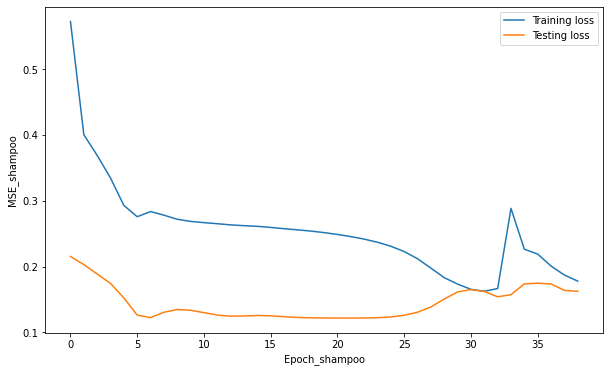

In [35]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_shampoo, label="Training loss")
plt.plot(val_loss_shampoo, label="Testing loss")
plt.xlabel("Epoch_shampoo")
plt.ylabel("MSE_shampoo")
plt.legend()
plt.show()

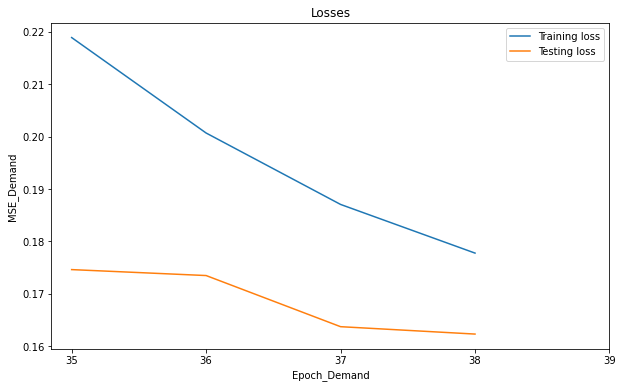

In [36]:
# Zoom in by fill in start_epoch and end_epoch
start_epoch = 35
end_epoch = 40
plt.figure(figsize=(10,6))
plt.plot(train_loss_shampoo[start_epoch:end_epoch], label="Training loss")
plt.plot(val_loss_shampoo[start_epoch:end_epoch], label="Testing loss")
plt.title("Losses")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
position=range(end_epoch-start_epoch)
labels=range(start_epoch,end_epoch)
plt.xticks(position, labels)
plt.legend()
plt.show()

In [37]:
#Make predictions
y_train_prediction_shampoo= model_shampoo(trainX_shampoo)
y_test_prediction_shampoo= model_shampoo(testX_shampoo)

#Reshape to original data
y_train_prediction_shampoo = torch.reshape(y_train_prediction_shampoo,(y_train_prediction_shampoo.shape[0],y_train_prediction_shampoo.shape[1]))
trainY_shampoo = torch.reshape(trainY_shampoo,(trainY_shampoo.shape[0],trainY_shampoo.shape[1]))
y_test_prediction_shampoo = torch.reshape(y_test_prediction_shampoo,(y_test_prediction_shampoo.shape[0],y_test_prediction_shampoo.shape[1]))
testY_shampoo = torch.reshape(testY_shampoo,(testY_shampoo.shape[0],testY_shampoo.shape[1]))

In [38]:
#Invert predictions
y_train_pred_shampoo = scaler.inverse_transform(y_train_prediction_shampoo.detach().numpy())
y_train_shampoo = scaler.inverse_transform(trainY_shampoo.detach().numpy())
y_test_pred_shampoo = scaler.inverse_transform(y_test_prediction_shampoo.detach().numpy())
y_test_shampoo = scaler.inverse_transform(testY_shampoo.detach().numpy())

In [39]:
y_test_shampoo.shape

(9, 1)

In [40]:
print("y-test\t\ty-predict")
for i in range(len(y_test_shampoo)):
    print(f"{y_test_shampoo[i]}\t\t{y_test_pred_shampoo[i]}")

y-test		y-predict
[439.3]		[429.9825]
[401.30002]		[409.7891]
[437.4]		[421.34515]
[575.5]		[416.2312]
[407.60004]		[528.34485]
[682.]		[473.67206]
[475.3]		[521.1427]
[581.3]		[598.19543]
[646.9]		[552.2374]


In [41]:
print(f"y_test_shape : {y_test_shampoo.shape}")   
print(f"y_test_pred_shape : {y_test_pred_shampoo.shape}")

y_test_shape : (9, 1)
y_test_pred_shape : (9, 1)


In [42]:
#calculate root mean squared error
trainScore_shampoo = math.sqrt(mean_squared_error(y_train_shampoo[:,0], y_train_pred_shampoo[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_shampoo))
testScore_shampoo = math.sqrt(mean_squared_error(y_test_shampoo[:,0], y_test_pred_shampoo[:,0]))
print('Test Score: %.2f RMSE' % (testScore_shampoo))

Train Score: 61.09 RMSE
Test Score: 102.80 RMSE


In [43]:
# Adjust to make the sequence data plot on original test data 
a=range(split_data+window_size_shampoo,split_data+len(y_test_shampoo)+window_size_shampoo)

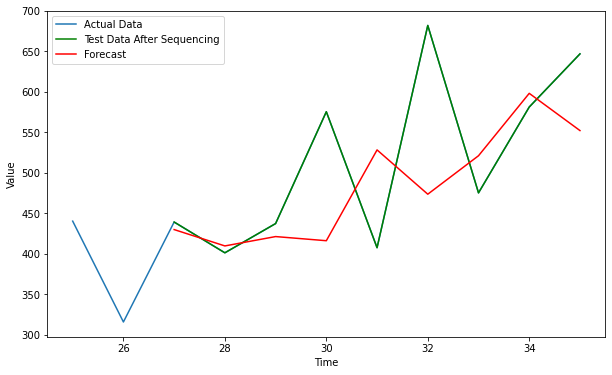

In [46]:
plt.figure(figsize=(10,6))
plt.plot(test_time,test_data_shampoo, label = 'Actual Data')
plt.plot(a,y_test_shampoo, color="green",label = 'Test Data After Sequencing')
plt.plot(a,y_test_pred_shampoo,color="red", label = 'Forecast')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

## Reference
1. Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee